
#### Forecast using Air Passenger Data
Here the famous Air Passenger dataset is use to create on step ahead forecast models using recurrent neural networks.  

+ LSTM cells take input of the (n_obs, n_xdims, n_time)
+ Statefull networks require the entire sequence of data to be preprocessed
+

In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, BatchNormalization, Activation
%matplotlib inline  

url = 'https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/AirPassengers.csv'
airPass = pd.read_csv(url)
airPass.index = airPass['time']
airPass.drop(['Unnamed: 0','time'], inplace=True, axis=1)
airPass.head()

,value
time,
1949.000000,112
1949.083333,118
1949.166667,132
1949.250000,129
1949.333333,121


#### Data Pre Processing for Forecasting
+ data is lag so that time x = time0 and y= time +1 (One Step ahead)
+ in this example, x is used twice to simulate a multi dimension x input for forecasting
+ X, and Y sides are scale between (0,1) ( we will reverse the scaling for calculating error metrics
+ Y is scaled so that the loss propagating back is all on the same scale, does create instablility

In [24]:
n_obs = len(airPass['value'].values)
n_ahead = 1 # in this case th
n_time_steps = 12 # each observation will have 12 months of data
n_obs_trimmed = int(n_obs/n_time_steps)
n_xdims = 1 # created by hstacking the sequence to simumlate multi dimensional input
n_train_obs = 9
n_outputs = 12

x = np.reshape(airPass['value'].values[0:n_obs_trimmed * n_time_steps  ], (-1, 1))
scaler = MinMaxScaler().fit(x) 
x_scaled = scaler.transform(x)
x_reshaped_scaled = np.reshape(x_scaled, (-1,n_xdims ,n_time_steps ))

# trains on only the first n_train_observations, lags by n_ahead (in this case one year)
X_train = x_reshaped_scaled[0:n_train_obs]
y_train =  x_reshaped_scaled[n_ahead:(n_train_obs + n_ahead)].squeeze()   # squeeze reshapes from 3 to 2d

# test on full data set 
X_test = x_reshaped_scaled[n_ahead:]
y_test =  x_reshaped_scaled[n_ahead:].squeeze()   

print('(n_years ie: obs), (n_xdims) , (time_steps ie months to consider)')
print('x_train: {0}, y_train: {1}'.format(X_train.shape, y_train.shape))
print('x_test: {0}, y_test: {1}'.format(X_test.shape, y_test.shape))


(n_years ie: obs), (n_xdims) , (time_steps ie months to consider)
x_train: (9, 1, 12), y_train: (9, 12)
x_test: (11, 1, 12), y_test: (11, 12)


#### Modeling
Keras lstm with 12 cells is used, with 12 outputs (one for each month of the year)
This forecasting system will forecast an entire year at a time. 
+ Dropout is used to prevent over fitting
+ one row of input to this model is essentually 12 months of passenger counts of shape (1, 1, 12)

In [71]:
from keras.callbacks import EarlyStopping
esm = EarlyStopping(patience=4)

# design network
model = Sequential()

model.add(LSTM(12, input_shape=(n_xdims, n_time_steps ),return_sequences=False,  
               dropout=0.2, recurrent_dropout=0.2, stateful=False, batch_size=1))
model.add(Dense(n_outputs ))
model.add(Activation('linear'))
model.compile(loss='mae', optimizer='adam')
model.summary()

# fit the model
history = model.fit(X_train,y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), verbose=0, shuffle=False, callbacks=[esm])

print('mse last 5 epochs {}'.format(history.history['val_loss'][-5:]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (1, 12)                   1200      
_________________________________________________________________
dense_9 (Dense)              (1, 12)                   156       
_________________________________________________________________
activation_9 (Activation)    (1, 12)                   0         
Total params: 1,356
Trainable params: 1,356
Non-trainable params: 0
_________________________________________________________________
mse last 5 epochs [0.0445328104225072, 0.045325480909510094, 0.04572556675835089, 0.04841325178065083, 0.053399924358183685]


##### Peformance on Entire Dataset
Peformance is check across the entire dataset using mean squared error and R2_score
The MaxMin scaler is reversed to get predictions back on the orignal scale 

In [72]:
preds = scaler.inverse_transform(np.reshape(model.predict(X_test, batch_size=1), (-1, 1))).flatten()
y_true = airPass['value'].values[n_time_steps:]
val_df = pd.DataFrame({'preds': preds, 'y_true':y_true})
mse = round(mean_squared_error(y_true, preds), 3)
r2 = round(r2_score(y_true, preds), 3)
print('performance on entire data sets mse: {} r2: {}'.format(mse, r2))

performance on entire data sets mse: 997.776 r2: 0.925


##### Peformance on Test Set
Since the last two years (24 timesteps) were held out as a test, we can test performance just on that portion
The MaxMin scaler is reversed to get predictions back on the orignal scale. This should show a small drop in performance.

In [74]:
y_true_test = airPass['value'].values[n_time_steps:][-24:]
preds_test = preds[-24:]
mse_test = round(mean_squared_error(y_true_test, preds_test), 3)
r2_test = round(r2_score(y_true_test, preds_test), 3)
print('performance on last two years only in the test set, mse: {} r2: {}'.format(mse_test, r2_test))

performance on last two years only in the test set, mse: 648.259 r2: 0.884


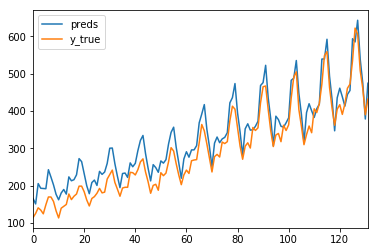

In [63]:
val_df.plot()